In [97]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.metrics import Precision
import cv2

In [69]:
# Create Spectrogram Image 
model = "MSK101D" 
condition = "new" # old or new
bearing = "ACBB"
speed = 5000 # 5000/7500/10000

data_folder = f"Model_data/{condition}_{bearing}_{speed}/"
save_folder = f"spectrogram/{model}_{bearing}_{speed}/{condition}"

os.makedirs(save_folder, exist_ok=True)
csv_files = sorted(glob.glob(os.path.join(data_folder, "*.csv")))

for file_idx, file_path in enumerate(csv_files, start=1):

    df = pd.read_csv(file_path)

    for cycle in range(1, 31):

        df_cycle = df[df['cycle_number'] == cycle].copy()
        if df_cycle.empty:
            continue

        # ---- Combined signal ----
        df_cycle['signal'] = np.sqrt(
            df_cycle['x']**2 +
            df_cycle['y']**2 +
            df_cycle['z']**2
        )

        # Remove DC
        signal = df_cycle['signal'].values.astype(float)
        signal -= signal.mean()

        fs = len(signal)   # 1-second recording

        # ---- Spectrogram ----
        f, t, Sxx = spectrogram(
            signal,
            fs=fs,
            nperseg=256,
            noverlap=128
        )

        # ---- Plot & save ----
        plt.figure(figsize=(6, 3))
        plt.pcolormesh(t, f, Sxx, shading='gouraud')
        plt.axis('off')
        plt.tight_layout(pad=0)

        save_name = f"{file_idx}_{cycle:02d}.png"
        plt.savefig(
            os.path.join(save_folder, save_name),
            dpi=600,
            bbox_inches='tight'
        )

        plt.close()

In [71]:
model = "MSK101D" 
bearing = "ACBB"
speed = 5000

#Get image data 
data = tf.keras.utils.image_dataset_from_directory(f"spectrogram/{model}_{bearing}_{speed}", image_size=(256, 256), batch_size=32) 
#Data normalization
data = data.map(lambda X,y: (X/255, y))

Found 420 files belonging to 2 classes.


In [136]:
def train_model(train_data, val_data):
    model = Sequential()

    #adding a convolutional layer and max pooling layer with 16 filters 3X3 pixels
    model.add(Conv2D(16, (3,3), strides=1,input_shape=(256,256,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(32, (3,3), strides=1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(64, (3,3), strides=1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D())
    

    #condense the rows and the width into a single value
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    
    #fully connected layers
    model.add(Dense(128, activation = 'relu'))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')])
    
    #train the model 10 times across whole dataset. val_data is used to evaluate how well the model performs in real time
    model.fit(train_data, epochs = 30, validation_data = val_data)

    return model

In [137]:
train_size = int(len(data) * .7)
val_size = int(len(data)*.2) +1
test_size = int(len(data) * .1) +1

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size).take(test_size)

In [138]:
#traied data is stored in keras_model
cnn_model = train_model(train_data, val_data)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4851 - auc: 0.5556 - loss: 0.6930 - val_accuracy: 0.5104 - val_auc: 0.4694 - val_loss: 0.6948
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5121 - auc: 0.4735 - loss: 0.6965 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6938
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4717 - auc: 0.4830 - loss: 0.6961 - val_accuracy: 0.5312 - val_auc: 0.7549 - val_loss: 0.6912
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4859 - auc: 0.4789 - loss: 0.6944 - val_accuracy: 0.5625 - val_auc: 0.5000 - val_loss: 0.6921
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6286 - auc: 0.6387 - loss: 0.6899 - val_accuracy: 0.7083 - val_auc: 0.6196 - val_loss: 0.6915
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5392 - auc: 0.5892 - loss: 0.6912 - val_accuracy: 0.5104 - val_auc: 0.7128 - val_loss: 0.6902
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.55

In [142]:
def model_evaluation(model, test_data):
    y_pred = model.predict(test_data).flatten()
    
    # Get the actual labels of test data
    y_true = np.concatenate([y for _, y in test_data])
    colors = ['green' if y == 0 else 'red' for y in y_true]


    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(y_pred)), y_pred, c = colors, alpha=0.7)

    plt.xlabel("Test sample index")
    plt.ylabel("Closeness to faulty state")
    plt.title("Model prediction confidence per test sample")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()
    


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step
(32, 256, 256, 3)


2026-01-20 16:05:18.624765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-01-20 16:05:23.706676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


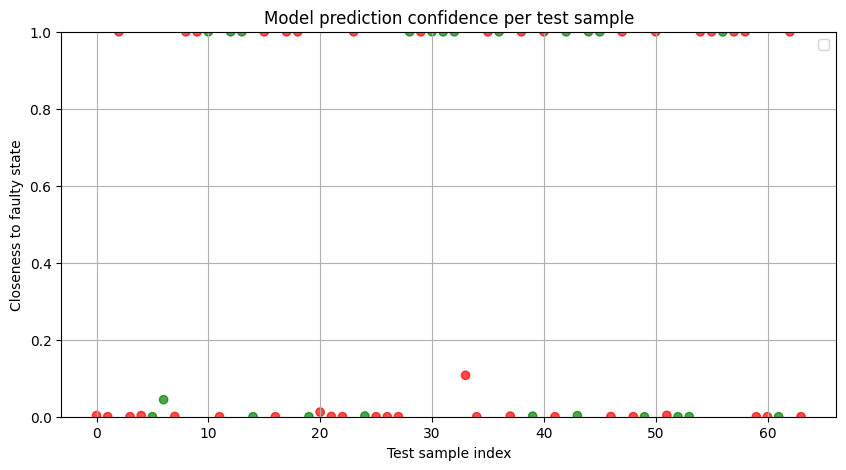

In [143]:
model_evaluation(cnn_model, test_data)